In [32]:
import numpy as np
import matplotlib.pyplot as plt


from hnc_n_multiscale import  HNC_solver

# Two Species

Here we do QSP interactions between electrons and one ion type. 

Using $\tilde{r}\equiv r/r_s$, we implement potentials 
\begin{align}
\beta v_{ee}(\tilde{r}) &=  \frac{\Gamma_{ee}}{\tilde{r}}\left( 1- \exp[-\tilde{r} r_s/\Lambda_e]\right) +  \ln2 \exp\left[-\tilde{r}^2 r_s^2/(\pi \Lambda_e^2 \ln 2)\right]\\
\beta v_{ei}(\tilde{r}) &=  \frac{\Gamma_{ei}}{\tilde{r}}\left( 1- \exp[-\tilde{r} r_s/\Lambda_e]\right)\\
\beta v_{ii}(\tilde{r}) &=  \frac{\Gamma_{ii}}{\tilde{r}}
\end{align}
For  
\begin{align}
\Gamma_{ee}&=\frac{\beta e^2}{r_s}\\
\Gamma_{ei}&=\frac{\beta Z_i e^2}{r_s}\\
\Gamma_{ii}&=\frac{\beta Z_i^2 e^2}{r_s}\\
\end{align}

Define physical constants

# Check ALL Tei stuff

In [33]:
m_e = 1
m_p = 1833.274
eV = 0.0367512 # So 4 eV = 4 * 0.036.. in natural units
Kelvin = 8.61732814974493e-5*eV #Similarly, 1 Kelvin = 3.167e-6... in natural units 
aB = 5.29177210903e-11 # Bohr radius in m

π = np.pi
# [AU]
# ni = 6e20*1e6*aB**3
# ri = (4/3*π*ni)**(-1/3)

ri=3
ni = (4/3*π*ri**3)**-1

Te   = 1*eV 
Ti   = 1*eV 

βe   = 1/Te
βi   = 1/Ti

Zstar = 3#

A = 27
m_i = m_p*A
μ_ei = m_i*m_e/(m_e+m_i) #reduced mass
Tie = μ_ei * (Te/m_e + Ti/m_i) #thermal velocity defined Tei
βie = 1/Tie

ne = Zstar*ni
re = (4/3*π*ne)**(-1/3)

E_F = 1/(2*m_e) * (3*π**2 * ne)**(2/3)
v_F = np.sqrt(2*E_F/m_e)
θ   = Te/E_F

lambda_TF = np.sqrt( Te / (4*np.pi*ne)  )

Λe   = np.sqrt(  βe*2*π /m_e )
Λeff = np.sqrt(6*π) / np.sqrt( 3*Te/m_e + 0.6*v_F**2)/m_e

Λe_star  = Λeff/ri
print("Λee = {0:.3f}".format(Λe_star))
Γee = βe/ri 
Γei = -Zstar*βie/ri
Γii = Zstar**2*βi/ri 


print("Γii={0:.1f}, Γie={1:.1f}, Γee={2:.1f} ".format(Γii, Γei, Γee))
print("r_i={0:.1f}".format(ri))
print("r_e={0:.1f}".format(re))
print("θ  ={0:.2e}".format(θ))

def βv_Yukawa(r):
    return Γii/r * np.exp(-r*ri/lambda_TF)

Λee = 1.836
Γii=81.6, Γie=-27.2, Γee=9.1 
r_i=3.0
r_e=2.1
θ  =8.63e-02


##### Load MM Data

In [34]:
# from pandas import read_csv

# r_ie, gie = np.array(read_csv("~/plasma/MM_HNC/gie.out", delim_whitespace=True)).T
# r_ee, gee = np.array(read_csv("~/plasma/MM_HNC/gee.out", delim_whitespace=True)).T
# r_ii, gii = np.array(read_csv("~/plasma/MM_HNC/gii.out", delim_whitespace=True)).T

# data_to_compare = [gie,gee,gii]
# data_to_compare = ["~/plasma/MM_HNC/gie.out","~/plasma/MM_HNC/gee.out","~/plasma/MM_HNC/gii.out"]
# data_names=['MM ie', "MM ee", 'MM ii' ]

Plug into get potentials

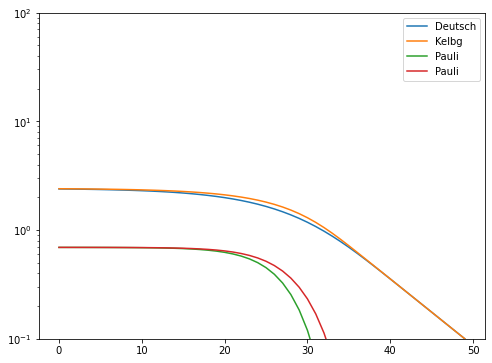

In [50]:
from scipy.special import erfc

# Build Components for QSP's

def βv_Deutsch(Γ, r):
    return Γ/r* ( 1 -  np.exp(-np.sqrt(2)*π*r/Λe_star) )

# Kelbg looks really weird??
def βv_Kelbg(Γ,r):
    return Γ/r*( 1 - np.exp(-2*π*r**2/Λe_star**2)+ np.sqrt(2)*π*r/Λe_star*erfc(np.sqrt(2*π)*r/Λe_star))

def βv_Pauli1(r):
    #Sarkas
    return  np.log(2) * np.exp(-4*π* r**2 /( Λe_star**2))

def βv_Pauli2(r):
    # Jones + Murillo Eqn.
    return  -np.log(1-0.5*np.exp(-2*π*r**2/Λe_star**2))


######### Build Actual QSP's

def βvee(r):
    return βv_Kelbg(Γee,r) + βv_Pauli(r)

def βvei(r):
    return βv_Kelbg(Γei,r)

# def βvei_atomic(r):
#     r_c = 3/5 #3/5 r_s in linear n_b(r) model
#     return np.heaviside(r - r_c,0.5) * βvei(r)

def βvii(r):
    return Γii/r 

fig, ax = plt.subplots(figsize=(8,6),facecolor='w')

xs = np.geomspace(1e-2,10)
ax.plot(βv_Deutsch(1,xs),label='Deutsch')
ax.plot(βv_Kelbg(1,xs),label='Kelbg')
ax.plot(βv_Pauli1(xs),label='Pauli')
ax.plot(βv_Pauli2(xs),label='Pauli')
ax.set_yscale('log')
ax.set_ylim(1e-1,1e2)
ax.legend()

First, we initialize the hnc

In [43]:
N_species = 2
Gamma = np.array(  [[Γii,  Γei],
                    [Γei,  Γee]])


# Gamma = np.array(  [[50,  10],
#                     [10,  10]])

names = ["Ion-1", "Electron", ] 
kappa = 1
rho = np.array([  3/(4*np.pi), Zstar*3/(4*np.pi) ])
hnc2 = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-6,
                 kappa_multiscale=1, rho = rho, num_iterations=int(100), 
                 R_max=10, N_bins=1000, names=names, dst_type=3)



In [44]:
βu_r_matrix = np.array([[βvii(hnc2.r_array), βvei(hnc2.r_array)],
                        [βvei(hnc2.r_array), βvee(hnc2.r_array)]])

hnc2.set_βu_matrix(βu_r_matrix)
hnc2.initialize_c_k()
hnc2.set_C_matrix()

/home/zach/plasma/hnc/hnc_n_multiscale.py:458: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(0,10)


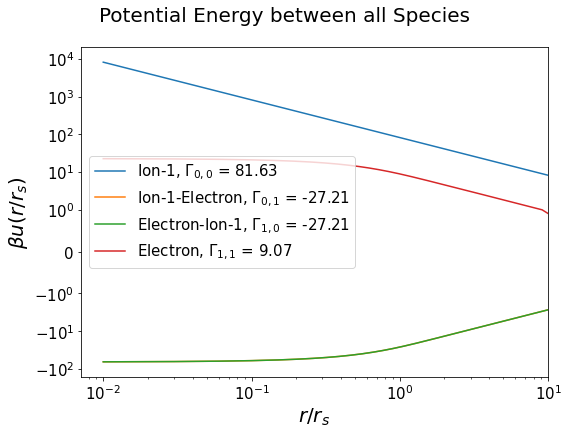

In [45]:
hnc2.plot_βu_all_species()

In [46]:
hnc2.HNC_solve(alpha=1e-1, h_max=1e4)

0: Err in c_r: 178.153
1: Err in c_r: 173.677
2: Err in c_r: 167.236
3: Err in c_r: 158.857
4: Err in c_r: 149.208
5: Err in c_r: 139.110
6: Err in c_r: 129.153
7: Err in c_r: 119.659
8: Err in c_r: 110.776
9: Err in c_r: 102.547
10: Err in c_r: 94.966
11: Err in c_r: 88.001
12: Err in c_r: 81.609
13: Err in c_r: 75.745
14: Err in c_r: 70.363
15: Err in c_r: 65.422
16: Err in c_r: 60.883
17: Err in c_r: 56.709
18: Err in c_r: 52.869
19: Err in c_r: 49.334
20: Err in c_r: 46.076
21: Err in c_r: 43.073
22: Err in c_r: 40.303
23: Err in c_r: 37.745
24: Err in c_r: 35.383
25: Err in c_r: 33.200
26: Err in c_r: 31.181
27: Err in c_r: 29.313
28: Err in c_r: 27.583
29: Err in c_r: 25.982
30: Err in c_r: 24.498
31: Err in c_r: 23.124
32: Err in c_r: 21.849
33: Err in c_r: 20.668
34: Err in c_r: 19.572
35: Err in c_r: 18.557
36: Err in c_r: 17.616
37: Err in c_r: 16.745
38: Err in c_r: 15.939
39: Err in c_r: 15.194
40: Err in c_r: 14.506
41: Err in c_r: 13.873
42: Err in c_r: 13.290
43: Err in 

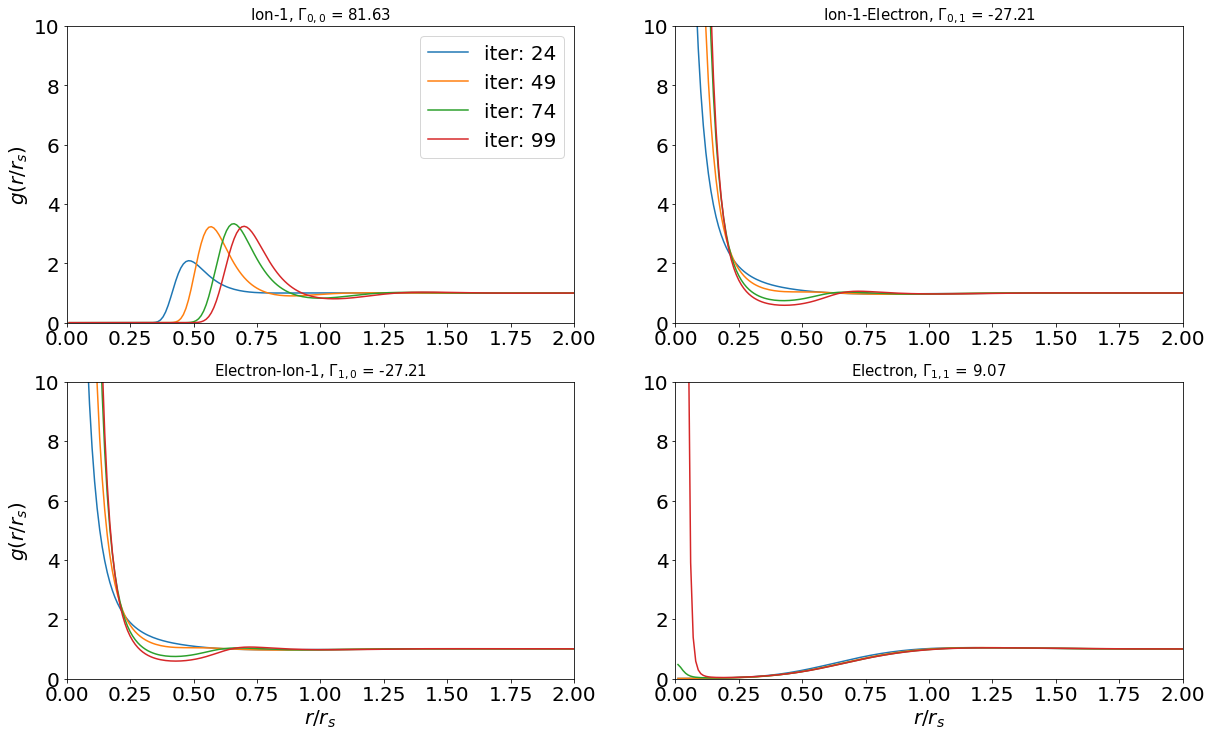

In [47]:
hnc2.plot_species_convergence()

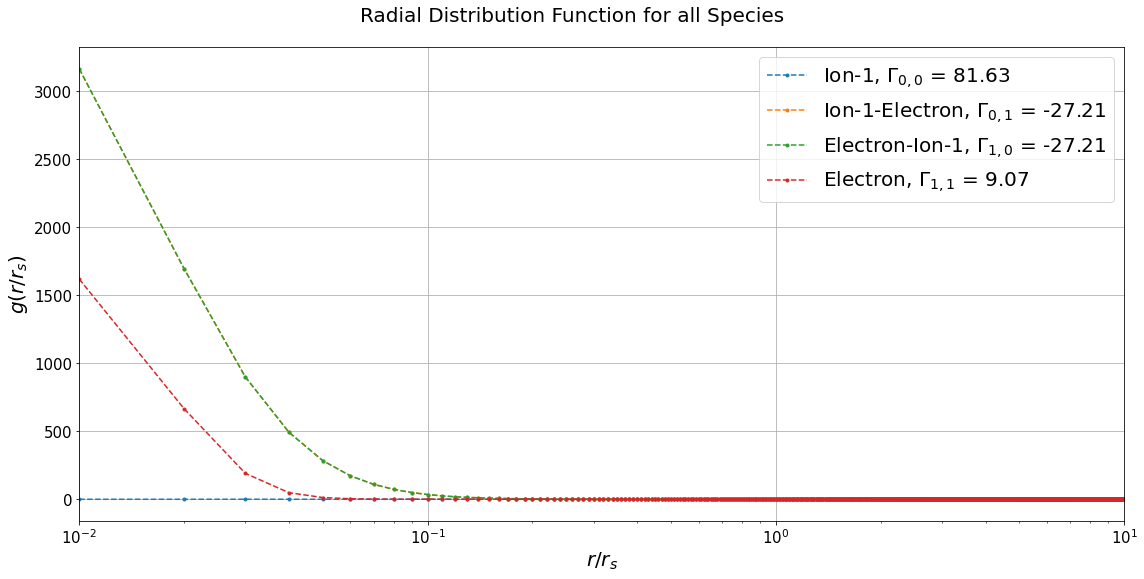

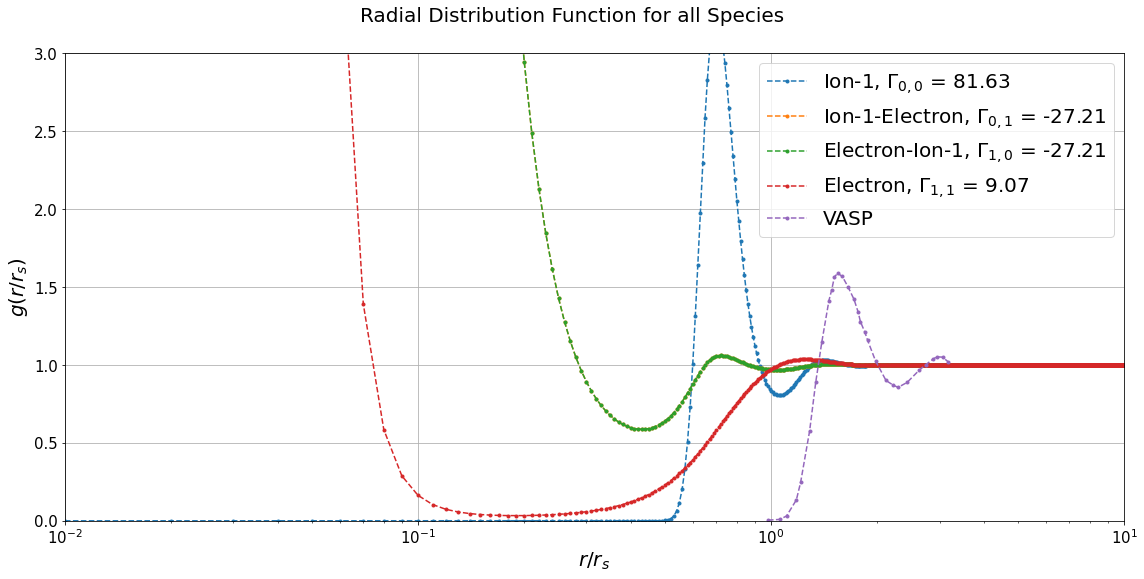

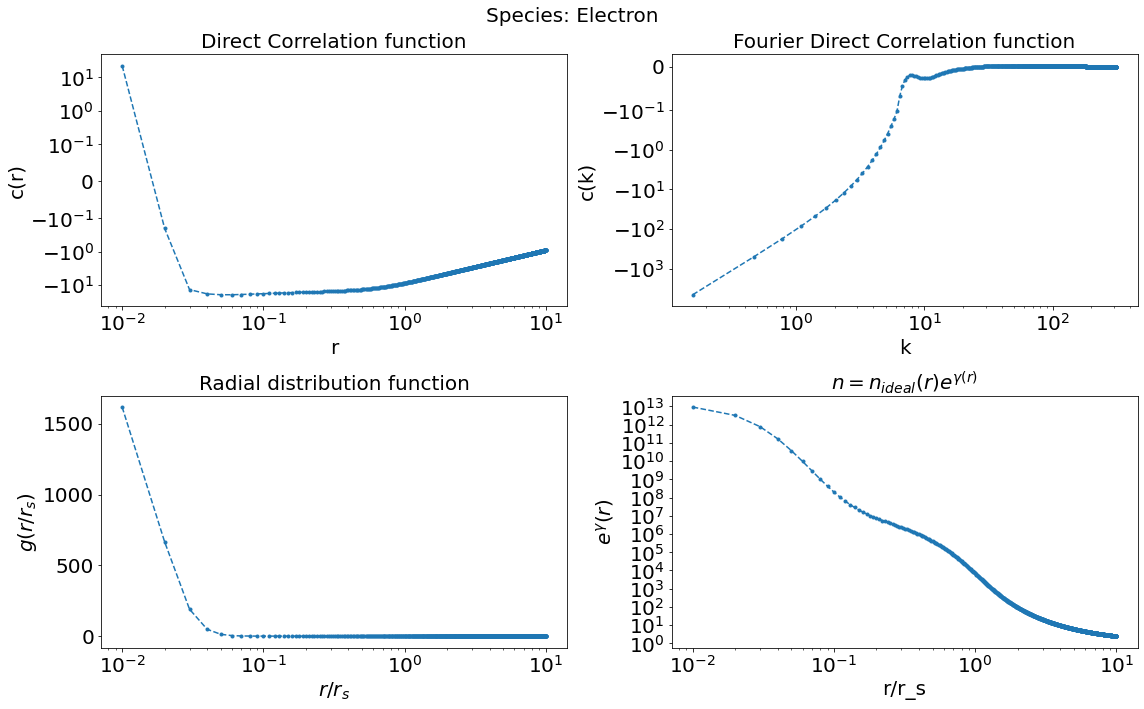

In [48]:
hnc2.plot_g_all_species()
hnc2.plot_g_all_species(gmax=3,data_to_compare=['/home/zach/plasma/atomic_forces/data/RDF/Al_1.0eV_rs3_VASP.txt'], data_names=['VASP'])
hnc2.plot_species((1,1))

In [ ]:
np.savetxt("/home/zach/Downloads/Al_1.0eV_r3_QSPHNC.txt",np.array([hnc2.r_array,hnc2.h_r_matrix[0,0]+1]).T)

# Effective Potentials

In [ ]:
hnc2.invert_HNC(1)

In [ ]:
fig, ax = plt.subplots()

ax.plot(hnc2.r_array, 1+hnc2.heff_r_matrix[0,0],label= 'h')
ax.plot(hnc2.r_array, hnc2.ceff_r_matrix[0,0],label='c')
ax.plot(hnc2.r_array,np.log(1+hnc2.heff_r_matrix)[0,0],label='log(1+h)')
ax.set_yscale('symlog',linthresh=1e-5)
ax.set_xlim(1e-1,2)
# ax.set_xscale('log')
ax.legend()

In [ ]:
hnc2.βωeff_r_matrix

In [ ]:
from pandas import read_csv
from scipy.interpolate import interp1d
luke_file = '/home/zach/plasma/atomic_forces/data/Al_T1_tab.lammps.PAIR'

luke_data = read_csv(luke_file ,delim_whitespace=True,header=3, names=['r [A]','V [eV]','F [eV/A]'])
luke_r, luke_βV = 1e-10/aB/ri*luke_data['r [A]'], 1/(Te/eV)*luke_data['V [eV]']
luke_r[165], luke_βV[165]
luke_βV_function = interp1d(luke_r, luke_βV,fill_value='extrapolate',bounds_error=False)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6),facecolor='w')
fig.suptitle(r"$T=${0:.1f} eV, $r_i$={1:.2f}".format(Te/eV,ri), fontsize=20)

ax.plot(luke_r, luke_βV,'k--', label="Luke Force Match")
ax.plot(hnc2.r_array, hnc2.βueff_r_matrix[0,0],'k-', label="Effective")
ax.plot(hnc2.r_array, hnc2.βu_r_matrix[0,0], label="Initial")
ax.plot(hnc2.r_array, βv_Yukawa(hnc2.r_array),label="Yukawa")
ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.set_ylim(-1,1e4)
ax.set_yscale('symlog',linthresh=1)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)

# Check!

In [ ]:
# N_species = 1
# Gamma = np.array(  [[1]])
# names = ["Ion Effective"] 
# kappa = 1
# rho = np.array([3/(4*np.pi)])
# hnc_check = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-3, kappa_multiscale=10,
#                        rho = rho, num_iterations=int(1e3), R_max=10, N_bins=1000, names=names)

# hnc_luke = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-3, kappa_multiscale=10,
#                        rho = rho, num_iterations=int(1e4), R_max=10, N_bins=1000, names=names)

# # check
# βu_r_matrix = np.nan_to_num( hnc2.βueff_r_matrix,nan = -np.log(1.e-16), posinf=-np.log(1e-16) ).copy()
# hnc_check.set_βu_matrix(βu_r_matrix)
# hnc_check.HNC_solve(alpha=1)

# # luke
# # βu_r_matrix[0,0]=luke_βV_function(hnc2.r_array)
# # hnc_luke.set_βu_matrix(βu_r_matrix)
# # hnc_luke.HNC_solve(alpha=1)


In [ ]:
# np.savetxt("example_veff_1eV_rs_3aBohr.txt", np.array([hnc_check.r_array, hnc_check.βu_r_matrix[0,0]]).T,header="r/r_s,   beta v_ii^eff   (both unitless)",delimiter=', ' )

In [ ]:
# hnc_check.plot_g_all_species()

In [ ]:
# fig, ax = plt.subplots(figsize=(10,6))

# ax.plot(hnc2.r_array, hnc2.h_r_matrix[0,0]+1,'.', label="Two Actual Species")
# ax.plot(hnc_check.r_array, hnc_check.h_r_matrix[0,0]+1,'-', label="One Effective Species")
# ax.plot(hnc_luke.r_array, hnc_luke.h_r_matrix[0,0]+1,'-', label="Luke HNC with Force Matched V")
# ax.set_ylabel(r'$g(r/r_s)$',fontsize=20)
# ax.set_xlabel(r'$r/r_s$',fontsize=20)
# ax.set_ylim(-0.1,3)
# ax.set_xlim(0,5)
# ax.tick_params(labelsize=15)
# ax.legend(fontsize=15)

# Curve Fitting

In [ ]:
from scipy.optimize import curve_fit

def yukawa_fit(r, Γ, κ,p):
    return  Γ/r*np.exp(-κ*r)

def yukawa_remaining_fit(r,a,b,c,d):
    return 1/(a+b*np.exp(c*(hnc2.r_array-d)))

def LJ_fit(r, a,b,m,n):
    return  1/(a*r**m + b/r**n) #+ v0

def yukawa_friedel_fit(r, Γ, κ1, a,κ2, k,  δ, v0):
    return  Γ/r*np.exp(-κ1*r) + a/r**3*np.exp(-κ2*r)*np.cos(k*r+δ) + v0

def yukawa_plus_fit(r, Γ, κ1, a,b,c):
    return  Γ/r*np.exp(-κ1*r)/(1+np.exp(b*(hnc2.r_array-c)))
# last_inf_index = int(np.argwhere(np.isinf(hnc2.βueff_r_matrix[0,0]))[-1] )

y_vals = curve_fit(yukawa_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0])
y_fit_data  = yukawa_fit(hnc2.r_array, y_vals[0][0],y_vals[0][1],y_vals[0][2])

y_remaining_vals = curve_fit(yukawa_remaining_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0]/y_fit_data)
y_remaining_fit_data  = yukawa_remaining_fit(hnc2.r_array, y_remaining_vals[0][0],y_remaining_vals[0][1],y_remaining_vals[0][2],y_remaining_vals[0][3])


# LJ_vals = curve_fit(LJ_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0],maxfev=int(1e5))
# yf_vals= curve_fit(yukawa_friedel_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0],maxfev=int(1e5))
# yp_vals= curve_fit(yukawa_plus_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0],maxfev=int(1e3))

In [ ]:
y_vals[0], y_remaining_vals[0]

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

g_data = hnc2.h_r_matrix[0,0] + 1

# LJ_fit_data  = LJ_fit(hnc2.r_array, LJ_vals[0][0],LJ_vals[0][1],LJ_vals[0][2],LJ_vals[0][3])
# yf_fit_data = yukawa_friedel_fit(hnc2.r_array, yf_vals[0][0],yf_vals[0][1],yf_vals[0][2],yf_vals[0][3],yf_vals[0][4],yf_vals[0][5],yf_vals[0][6])
# yp_fit_data = yukawa_plus_fit(hnc2.r_array, yp_vals[0][0],yp_vals[0][1],yp_vals[0][2],yp_vals[0][3],yp_vals[0][4])


ax.plot(hnc2.r_array, hnc2.βueff_r_matrix[0,0],'k-', label="Effective")
# ax.plot(hnc2.r_array, y_fit_data*y_remaining_fit_data,'--', label="Yukawa Fit")
ax.plot(hnc2.r_array, 81.87504124/hnc2.r_array*np.exp(-0.99115223*hnc2.r_array)/(0.92620556+0.7351028*np.exp(1.72217623*(hnc2.r_array-1.75197859))),'--', label="Fit")
# ax.plot(hnc2.r_array[1:], hnc2.βueff_r_matrix[0,0][1:]-hnc2.βueff_r_matrix[0,0][:-1],'k-', label="Effective")
# ax.plot(hnc2.r_array[1:], (y_fit_data*y_remaining_fit_data)[1:]-(y_fit_data*y_remaining_fit_data)[:-1],'--', label="Yukawa Fit")

# ax.plot(hnc2.r_array, LJ_fit_data,'--', label="Yukawa Fit")
# ax.plot(hnc2.r_array, hnc2.βueff_r_matrix[0,0]-y_fit_data*y_remaining_fit_data,'.', label="Yukawa Fit Ratio")
 
# ax.plot(hnc2.r_array,y_remaining_fit_data,'.', label="Yukawa Remaining Fit")

# ax.plot(hnc2.r_array, yf_fit_data,'.', label="Yukawa-Friedel Fit")
# ax.plot(hnc2.r_array, yp_fit_data,'.', label="Yukawa-Plus Fit")
# ax.plot(hnc2.r_array, hnc2.βueff_r_matrix[0,0]/yp_fit_data,'.', label="Yukawa-Plus Fit Ratio")
# ax.plot(hnc2.r_array, 1/(1+np.exp(3*(hnc2.r_array-2.5))),'.', label="Yukawa-Friedel Fit")

ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
# ax.set_ylim(-2,2)
ax.set_yscale('symlog',linthresh=1e-1)
ax.set_xlim(0,10)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)

In [ ]:
from scipy.interpolate import RBFInterpolator



RBFInterpolator(hnc2.r_array, hnc2.βueff_r_matrix[0,0]/y_fit_data)